In [1]:
import os
import numpy
import matplotlib.pyplot as plt

In [2]:
img_pkl_file = 'Domain_Files/SpatialPy_Image.pkl'
try:
    from PIL import Image, ImageDraw, ImageFont

    # name of the file to save
    filename = "img01.png"
    #fnt = ImageFont.truetype('arial.ttf', 15)
    fontsize=50
    fnt = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf',fontsize)
    # create new image
    image = Image.new(mode = "RGB", size = (230,70), color = "white")
    draw = ImageDraw.Draw(image)
    draw.text((10,10), "SpatialPy", font=fnt, fill=(0,0,0))

    image_array = numpy.asarray(image)
    if not os.path.isfile(img_pkl_file):
        import pickle
        with open(img_pkl_file,'wb') as p:
            pickle.dump(image_array,p)

except Exception:
    import pickle
    with open(img_pkl_file,'rb') as p:
        image_array = pickle.load(p)


In [3]:
image_array.shape

(70, 230, 3)

(2.8999999999999986, 225.1, 9.85, 57.15)

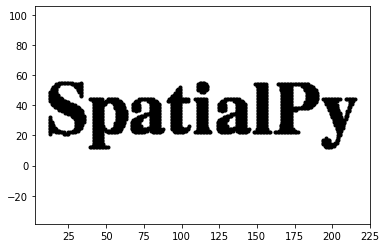

In [4]:
word_points_x = []
word_points_y = []
for y in range(image_array.shape[0]):
    for x in range(image_array.shape[1]):
        if image_array[y, x, 0] < 50:
            word_points_x.append(x)
            word_points_y.append(-y + image_array.shape[0])
plt.plot(word_points_x, word_points_y, '.k')
plt.axis('equal')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.insert(0,'../')
import spatialpy
spatialpy.__file__

'/Users/bryanrumsey/Documents/SpatialPy/examples/../spatialpy/__init__.py'

In [7]:
class BouncyFloor(spatialpy.BoundaryCondition):
    def __init__(self):
        pass
    
    def expression(self):
        return """
        if(me->x[1] < system->ylo){
            me->x[1] = system->ylo;
            me->v[1] = -0.95 * me->v[1];
        }
        me->x[2]=0.0;
        me->rho = 1.0;
        """

In [8]:
class SpatialPyGravity(spatialpy.Model):
    def __init__(self, x_vals, y_vals, xmax, ymax):
        spatialpy.Model.__init__(self,"SpatialPy Gravity")
        
        domain = spatialpy.Domain(len(x_vals), (0, xmax), (0, ymax), (0, 0), gravity=[0, -1, 0])
        for i, x_val in enumerate(x_vals):
            domain.vertices[i, 0] = x_val
            domain.vertices[i, 1] = y_vals[i]
            domain.type[i] = 1
            domain.mass[i] = 1.0
            domain.vol[i] = 1.0
            domain.nu[i] = 1.0
        self.add_domain(domain)
        
        self.add_boundary_condition(BouncyFloor())
        
        self.staticDomain = False
        
        self.timespan(numpy.linspace(0, 50, 201), timestep_size=1e-3)

In [9]:
model = SpatialPyGravity(word_points_x,word_points_y,
                 image_array.shape[1],image_array.shape[0])

In [10]:
sol = spatialpy.Solver(model, debug_level=0)
%time sol.compile()

CPU times: user 30.6 ms, sys: 3.19 ms, total: 33.8 ms
Wall time: 706 ms


In [33]:
%time result = sol.run()

Got NaN calculating D_i_j for me=1224, neighbor=1152
system->dimension=2 r2=1.000000e+00 r2_old=1.000000e+00 r=1.000000e+00 h=3.111270e+00 alpha=1.644163e-01 dWdr=-9.385616e-02 mass=1.000000e+00 rho=0.000000e+00 n->mass=1.000000e+00 n->rho=0.000000e+00 x=[9.600000e+01,3.500000e+01,0.000000e+00] n->x=[9.600000e+01,3.600000e+01,0.000000e+00] solver_cmd = cd /var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_result_tgd2sxk6;/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_build_hex_9xhh/ssa_sdpd


SimulationError: Solver execution failed, return code = 1

In [12]:
result.plot_property('type')

NameError: name 'result' is not defined

In [ ]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(time=0,key='type',index=0):
    try:
        pts, data = result.read_step(time)
    except Exception:
        print("error reading time={0}".format(time))
        return
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('scaled')
    #plt.colorbar()
    plt.title('t={0}'.format(time*model.timestep_size*model.output_freq))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)
    plt.xlim(result.model.mesh.xlim)
    plt.ylim(result.model.mesh.ylim)
    
    
    
def plot_all(key='type',index=0):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key,index)

In [ ]:
# pts, data = result.read_step(0)
# plt.scatter(pts[:,0],pts[:,1],c=data['type'])
# plt.axis('scaled')
# #plt.colorbar()
# plt.title('t={0}'.format(0))
# #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
# #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
# plt.grid(linestyle='--', linewidth=1)
# plt.xlim(result.model.mesh.xlim)
# plt.ylim(result.model.mesh.ylim)

In [ ]:
#plot_all('v',index=1)

In [ ]:
len(result.get_timespan())

In [ ]:
# Animated plot of the data
#result.plot_property("rho", p_ndx=1, width=600, height=800, 
#                     animated=True, t_ndx_list=[t for t in range(0,len(result.get_timespan()))], 
#                     f_duration=1, t_duration=100, colormap="haline")

In [ ]:
result.plot_property("type", use_matplotlib=True, mpl_width=15, mpl_height=5)
result.plot_property("type", use_matplotlib=True, mpl_width=15, mpl_height=5, colormap="winter")

In [ ]:
def plot_all_plot_property(key='type',index=0):
    for i,t in enumerate(result.get_timespan()):
        try:
            result.plot_property(key, t_ndx=i, p_ndx=index, 
                                 use_matplotlib=True, mpl_width=17, 
                                 mpl_height=5)
        except:
            print("error reading time={0}".format(i))

In [ ]:
# this produces a lot of data
#plot_all_plot_property(key="v", index=1)

In [ ]:
result.plot_property("type", animated=True)

In [ ]:
import matplotlib